# Define Running Mode

- 'full_dataset = True' to use the full data set. If 'full_dataset = True', then a data set containing only data one year of the hobbies sales in TX2.  
    
- 'submit_to_kaggle = True' to submit the forecasts to Kaggle.  


In [1]:
full_dataset = True
submit_to_kaggle = False


# Import Packages

In [2]:
import utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import time
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

# Data Import and Preparation

In [3]:
if full_dataset:
    prefix = 'full_dataset'
else:
    prefix = 'subset'

df_merged = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/feature_engineering/{prefix}_df_merged.csv')

scaling_factors_rmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/scaling_factors_rmsse.csv')

weights_wrmsse = pd.read_csv(
    f'{utils.get_m5_root_dir()}/data/weights/weights_for_wrmsse.csv')


In [4]:
# downcast numerical values to reduce mem usage
df_merged = utils.reduce_mem_usage(df_merged)

Mem. usage of decreased to 4912.94 Mb (64.7% reduction)


# Model Training & Forecasting (LightGBM)

In [5]:
# Custom Loss & valid for asymetric rmse
def custom_mse_asymmetric_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    grad = np.where(residual < 0, -2 * residual, -2 * residual * 1.1)
    hess = np.where(residual < 0, 2, 2 * 1.1)
    print(grad)
    print('grad: ',len(grad))
    print('hess: ',len(hess))
    return grad, hess


def custom_rmse_asymmetric_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = np.where(residual < 0, (residual ** 2), (residual ** 2) * 1.1)
    print('val: ', len(loss))
    return "custom_mse_asymmetric_eval", np.sqrt(np.mean(loss)), False

In [6]:
scaling_factors_rmsse['item_id'] = scaling_factors_rmsse['id']
scaling_factors_rmsse = utils.encode_categorical(scaling_factors_rmsse,
                                                 cols=['item_id'],
                                                 fillna=True)
scaling_factors_rmsse.head(5)

Mem. usage of decreased to  0.41 Mb (30.0% reduction)


,id,scaling_factor,item_id
0,FOODS_1_001_CA_1_validation,2.764876,0
1,FOODS_1_001_CA_2_validation,5.288273,1
2,FOODS_1_001_CA_3_validation,10.082611,2
3,FOODS_1_001_CA_4_validation,0.976892,3
4,FOODS_1_001_TX_1_validation,3.630271,4


In [7]:
weights_wrmsse['item_id'] = weights_wrmsse['id']
weights_wrmsse = utils.encode_categorical(weights_wrmsse,
                                                 cols=['item_id'],
                                                 fillna=True)
weights_wrmsse.head(5)

Mem. usage of decreased to  0.41 Mb (30.0% reduction)


,id,weights,item_id
0,FOODS_1_001_CA_1_validation,1.972157e-05,0
1,FOODS_1_001_CA_2_validation,1.852633e-05,1
2,FOODS_1_001_CA_3_validation,1.434296e-05,2
3,FOODS_1_001_CA_4_validation,5.378610e-06,3
4,FOODS_1_001_TX_1_validation,5.976234e-07,4


In [8]:
df_merged = df_merged.merge(
    scaling_factors_rmsse[['item_id', 'scaling_factor']], on='item_id').merge(
    weights_wrmsse[['item_id', 'weights']], on='item_id')
df_merged.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d,sale,date,wm_yr_wk,...,rolling_skew_t28,lag_t28,up_for_sale,price_change_t1,price_change_t30,rolling_price_std_t28,is_weekend,day,scaling_factor,weights
0,HOBBIES_1_001_CA_1_validation,1437,3,1,0,0,912,0.0,2011-07-29,11126,...,NaN,0.0,0,NaN,NaN,NaN,0,29,2.677643,0.000015
1,HOBBIES_1_001_CA_2_validation,1437,3,1,1,0,912,0.0,2011-07-29,11126,...,NaN,0.0,0,NaN,NaN,NaN,0,29,2.677643,0.000015
2,HOBBIES_1_001_CA_3_validation,1437,3,1,2,0,912,0.0,2011-07-29,11126,...,NaN,0.0,0,NaN,NaN,NaN,0,29,2.677643,0.000015
3,HOBBIES_1_001_CA_4_validation,1437,3,1,3,0,912,0.0,2011-07-29,11126,...,NaN,0.0,0,NaN,NaN,NaN,0,29,2.677643,0.000015
4,HOBBIES_1_001_TX_1_validation,1437,3,1,4,1,912,0.0,2011-07-29,11126,...,NaN,0.0,0,NaN,NaN,NaN,0,29,2.677643,0.000015


In [27]:
# TODO: proper feature selection (e.g. random forrest)
# for now: hardcoded list of features

cat_features = [
    'item_id',
    'dept_id',
    'cat_id',
    'store_id',
    'state_id',
    'year',
    'month',
    'day',
    'is_weekend',
    'wday',
    'event_name_1',
    'event_type_1',
    'event_name_2',
    'event_type_2',
    'snap_CA',
    'snap_TX',
    'snap_WI',
    'up_for_sale'
]

num_features = [
    'sell_price',
    'lag_t28',
    'rolling_kurt_t28',
    'rolling_skew_t28',
    'rolling_mean_t28',
    'rolling_std_t28',
    'price_change_t1',
    'price_change_t30',
    'rolling_price_std_t28',
]

features = cat_features + num_features

In [28]:
x_train = df_merged[df_merged['date'] <= '2016-03-27'][features]
y_train = df_merged[df_merged['date'] <= '2016-03-27']['sale']
scaling_train = df_merged[df_merged['date'] <= '2016-03-27']['scaling_factor'].to_numpy()
weights_train = df_merged[df_merged['date'] <= '2016-03-27']['weights'].to_numpy()


x_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27'][features]
y_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['sale']
scaling_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['scaling_factor'].to_numpy()
weights_val = df_merged.loc[df_merged['data_type'] ==
                      'train'].loc[df_merged['date'] > '2016-03-27']['weights'].to_numpy()

x_pred = df_merged[(df_merged['data_type'] == 'validation')][features]


print(x_train.shape)
print(y_train.shape)
print(scaling_train.shape)
print(weights_train.shape)
print(x_val.shape)
print(y_val.shape)
print(scaling_val.shape)
print(weights_val.shape)
print(x_pred.shape)

(51954960, 27)
(51954960,)
(51954960,)
(51954960,)
(853720, 27)
(853720,)
(853720,)
(853720,)
(853720, 27)


In [29]:
# Custom Loss & valid for scaled rmse (rmsse)
def custom_msse_loss(y_pred, y_true):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    
    grad = np.array(-2 * residual / scaling_train)
    hess = 2/scaling_train

    return grad, hess


def custom_rmsse_valid(y_pred, y_true, tmp=None):
    y_true = y_true.get_label()
    residual = (y_true - y_pred).astype("float")
    loss = residual ** 2
    
    if len(residual) in [89270, 51954960]: # len = 89270 for validation sub set
        factor = scaling_train
    else:
        factor = scaling_val
    scaled_loss = loss / factor
    return "custom_rmsse_valid", np.sqrt(np.mean(scaled_loss)), False

In [30]:
# create datasets
train_data = lgb.Dataset(x_train, label=y_train,
                         categorical_feature=cat_features, free_raw_data=False,
                       # weight=weights_train
                       )
validation_data = lgb.Dataset(
    x_val, label=y_val, categorical_feature=cat_features, free_raw_data=False, reference=train_data,
       # weight=weights_val
)

In [31]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'seed': 10,
    'learning_rate': 0.03,
    'bagging_fraction': 0.75,
    'bagging_freq': 10,
    'max_bin': 128,
    'feature_fraction ': 0.75,
}

evals_result = {}  # to record eval results for plotting

gbm = lgb.train(params, train_data, valid_sets=[train_data, validation_data],
                evals_result=evals_result, num_boost_round=1000,
                verbose_eval=25, early_stopping_rounds=20,
                fobj=custom_msse_loss,
                feval=custom_rmsse_valid
               )


y_pred = gbm.predict(x_pred)

c:\users\domin\anaconda3\envs\predicting-sales-data\lib\site-packages\lightgbm\basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 20 rounds
[25]	training's custom_rmsse_valid: 2.22861	valid_1's custom_rmsse_valid: 2.05006
[50]	training's custom_rmsse_valid: 1.99309	valid_1's custom_rmsse_valid: 1.79818
[75]	training's custom_rmsse_valid: 1.91803	valid_1's custom_rmsse_valid: 1.7275
[100]	training's custom_rmsse_valid: 1.88645	valid_1's custom_rmsse_valid: 1.70459
[125]	training's custom_rmsse_valid: 1.86728	valid_1's custom_rmsse_valid: 1.696
[150]	training's custom_rmsse_valid: 1.85341	valid_1's custom_rmsse_valid: 1.69216
[175]	training's custom_rmsse_valid: 1.84324	valid_1's custom_rmsse_valid: 1.6887
[200]	training's custom_rmsse_valid: 1.83459	valid_1's custom_rmsse_valid: 1.68708
[225]	training's custom_rmsse_valid: 1.82731	valid_1's custom_rmsse_valid: 1.68512
[250]	training's custom_rmsse_valid: 1.82134	valid_1's custom_rmsse_valid: 1.68351
[275]	training's custom_rmsse_valid: 1.81608	valid_1's custom_rmsse_valid: 1.68313
[300]	training's custom_rmsse_val

# Training Analysis

Plotting metrics recorded during training...


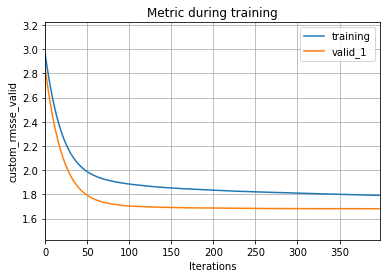

In [32]:
print('Plotting metrics recorded during training...')
ax = lgb.plot_metric(evals_result)
plt.show()

Plotting feature importances...


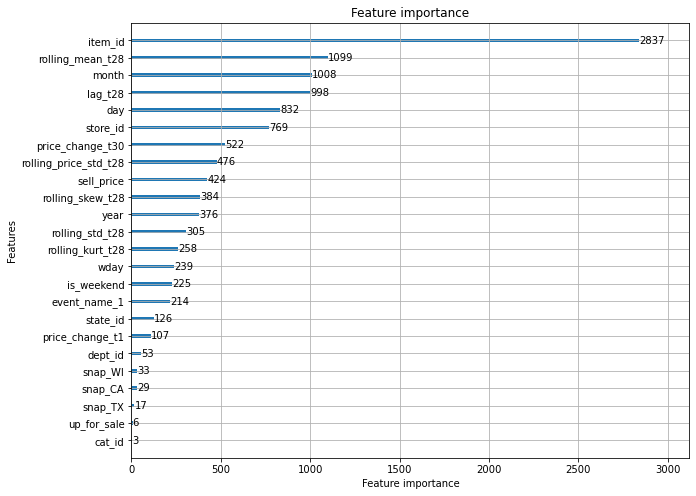

In [33]:
print('Plotting feature importances...')
ax = lgb.plot_importance(gbm, figsize=(10,8))
plt.show()

# Printout Forecasts

In [34]:
# map forecast values to encoded item_ids
x_val['y_pred'] = y_pred

In [35]:
# map encoded ids to decoded ids
id_mapping_table = df_merged[['id', 'item_id', 'store_id']].drop_duplicates()
df_results = x_val.merge(id_mapping_table,
                         on=['item_id', 'store_id'],
                         how='left')[[
                             'id', 'item_id', 'store_id', 'year', 'month',
                             'day', 'y_pred'
                         ]]

In [36]:
# create dict with IDs and forecasts
submission_dict = {}

for i, df in df_results.groupby(['id']):
    df = df.reset_index(drop=True)
    submission_dict[i] = df['y_pred']

In [37]:
# convert dict to dataframe
submission_df = pd.DataFrame(submission_dict).T
submission_df = submission_df.clip(lower=0) # Convert negative values to 0
submission_df.reset_index(level=0, inplace=True)
submission_df.columns = ['id'] + [f'F{di}' for di in list(range(1, 29))]
submission_df.head(10)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_validation,0.789459,0.739200,0.736540,0.706074,1.066771,1.029882,1.088432,1.208276,0.958571,...,1.060424,1.383680,1.240132,1.335591,1.009385,1.015365,0.949293,1.003891,1.265395,1.166596
1,FOODS_1_001_CA_2_validation,0.803295,0.784957,0.783242,0.774953,0.768469,0.858619,0.899873,0.605401,0.606267,...,0.472350,0.515316,2.677905,0.976640,0.940479,0.940479,1.283003,1.060708,1.210447,1.622327
2,FOODS_1_001_CA_3_validation,1.161575,1.008716,1.024581,0.969376,1.019603,1.218047,1.224916,1.049915,1.024253,...,1.183961,1.329735,3.065851,1.449524,1.259342,1.217769,1.218114,1.267098,1.450159,1.404246
3,FOODS_1_001_CA_4_validation,0.548988,0.451084,0.450397,0.450397,0.475297,0.539421,0.544821,0.545966,0.497352,...,0.297204,0.350591,0.333475,0.396929,0.264950,0.247698,0.248043,0.316294,0.386729,0.423303
4,FOODS_1_001_TX_1_validation,0.476051,0.457713,0.457026,0.457026,0.486326,0.573590,0.614941,0.517734,0.477224,...,0.309721,0.328875,0.334023,0.247458,0.175064,0.175064,0.175410,0.195115,0.225535,0.224817
5,FOODS_1_001_TX_2_validation,0.566356,0.537984,0.518763,0.727388,0.600174,0.493066,0.510444,0.438063,0.412750,...,0.711162,0.498450,0.581111,0.436958,0.407872,0.394131,0.394476,0.415342,0.529347,0.465224
6,FOODS_1_001_TX_3_validation,0.356076,0.342138,0.341451,0.327319,0.406152,0.491070,0.524373,0.417173,0.452251,...,0.415246,0.540542,0.582294,0.421526,0.339977,0.339977,0.488319,0.448592,0.497522,0.496804
7,FOODS_1_001_WI_1_validation,0.385483,0.393671,0.362518,0.392985,0.401884,0.487541,0.525120,0.421974,0.408444,...,0.389383,0.461623,0.552189,0.388574,0.438836,0.359488,0.359833,0.398349,1.320309,0.798547
8,FOODS_1_001_WI_2_validation,0.259208,0.240870,0.240183,0.240183,0.269484,0.309578,0.568393,0.370270,0.336430,...,0.478306,0.543320,0.558173,0.404624,0.424737,0.429317,0.399196,0.427646,0.498468,0.451247
9,FOODS_1_001_WI_3_validation,0.209757,0.191419,0.248881,0.248881,0.203916,0.261356,0.305144,0.240281,0.229620,...,0.244458,0.383819,0.350675,0.262813,0.210139,0.210139,0.210484,0.222272,0.671077,0.424199


# Submit to Kaggle 

In [38]:
if submit_to_kaggle:
    # Bring data to Kaggel's required form (evaluation & validation)
    df_submission = submission_df.append(
        submission_df.replace(to_replace='validation', value='evaluation',
                              regex=True))
    filename = utils.get_m5_root_dir(
    ) + '/data/submissions/gradient_boosting_regressor_v_2_5.csv'
    df_submission.to_csv(filename, index=False)
    

    # Submit via Kaggle API or with website https://www.kaggle.com/c/m5-forecasting-accuracy/submissions
    !kaggle competitions submit -c m5-forecasting-accuracy -f data/submissions/gradient_boosting_regressor_v_2_5.csv -m "asymetric loss with factor 1.1 if res > 1"


In [39]:
df_submission = submission_df.append(
    submission_df.replace(to_replace='validation', value='evaluation',
                          regex=True))
filename = utils.get_m5_root_dir(
) + '/data/submissions/gradient_boosting_regressor_v_3_0.csv'
df_submission.to_csv(filename, index=False)
